In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
# CONFIG
CYCLES = 15

N_BUYERS = 50
N_SELLERS = 50

DAYS = 100
SEATS = 100
TICKET_UTILITY = 1
TICKET_COST = 1

In [4]:
# SELLERS MATRIX
# columns: c, d, e, seats_left, profits
def init_sellers():
    sellers = np.zeros((N_SELLERS, 5))
    # c 
    sellers[:, 0] = 0.1 * np.random.randn(N_SELLERS)
    # d
    sellers[:, 1] = 0.1 * np.random.randn(N_SELLERS)
    # e
    sellers[:, 2] = 1 * np.random.randn(N_SELLERS)
    # seats_left
    sellers[:, 3] = np.random.poisson(SEATS, size=N_SELLERS)
    # intial profits negative -- each ticket leads to cost 1
    sellers[:, 4] = -sellers[:, 3]
    return sellers

# seller model
# price = c * days_left + d * seats_left + e  [NOT for now: + * days_left * seats_left]
def get_price(seller, days_left):
    price = seller[0] * days_left + seller[1] * seller[3] + seller[2]
    return np.maximum(price, 0)

# seller evolution
# evolve sellers with highest profits
def resample_sellers(sellers):
    scores = sellers[:, 4] - np.min(sellers[:, 4])
    p_replicate = scores/(np.sum(scores))
    
    indices_drawn = np.random.choice(np.arange(len(p_replicate)), size=len(p_replicate), p=p_replicate)
    sellers = sellers[indices_drawn, :]

    return sellers
    
def add_seller_noise(sellers):
    # c 
    sellers[:, 0] += 0.05 * np.random.randn(sellers.shape[0])
    # d
    sellers[:, 1] += 0.05 * np.random.randn(sellers.shape[0])
    # e
    sellers[:, 2] += 0.5 * np.random.randn(sellers.shape[0])
    
    return sellers


In [5]:
# BUYERS MATRIX
# columns: a, b, b2, tickets_bought, money_spent
def init_buyers():
    buyers = np.zeros((N_BUYERS, 6))
    # a 
    buyers[:, 0] = 1 * np.random.randn(N_BUYERS)
    # b
    buyers[:, 1] = 1 * np.random.randn(N_BUYERS)
    # b2
    buyers[:, 2] = 0.01 * np.random.randn(N_BUYERS)
    
    return buyers
    
# buyer model
# P(buy) = sigmoid(a * price + b + b2 * days_left)

def get_p_buy(buyers, price, days_left, seats_left):
    p = sigmoid(buyers[:, 0] * price + buyers[:, 1] + buyers[:, 2] * days_left)
#     p = np.clip((buyers[:, 0] * price + buyers[:, 1] + buyers[:, 2] * days_left), 0, 1)
    return p

def buy_tickets(buyers, seats_left, price, days_left):
    if seats_left <= 0:
        return 0, buyers
    
    p = get_p_buy(buyers, price, days_left, seats_left)
    roll = np.random.rand(len(p))
    
    orders = roll < p
    seats_sold = np.count_nonzero(orders)
    if seats_sold <= seats_left:
        lucky = orders
    else: # if not enough seats
        indices = np.arange(len(p))[orders]
        lucky = np.random.choice(indices, seats_left, replace=False)

    # add ticket
    buyers[lucky, 3] += 1
    # inc money spent
    buyers[lucky, 4] += price
    
    # discounting future money 
#     buyers[lucky, 4] += price / 2.25**((DAYS - days_left)/365)
    
    return min(seats_sold, seats_left), buyers

# buyer evolution
# evolve buyers that get the highest utility
# utility = 100 * tickets_bought - money_spent

def resample_buyers(buyers):
    utilities = TICKET_UTILITY * buyers[:, 3] - buyers[:, 4]
    utilities_shift = utilities - np.min(utilities)
    p_replicate = utilities_shift/np.sum(utilities_shift)
#     p_replicate = utilities_shift**2/np.sum(utilities_shift**2)
    
    indices_drawn = np.random.choice(np.arange(len(p_replicate)), size=len(p_replicate), p=p_replicate)
    buyers = buyers[indices_drawn, :]
    
    return buyers
    
def add_buyer_noise(buyers):
    # add noise
    # a
    buyers[:, 0] += 0.25 * np.random.randn(buyers.shape[0])
    # b
    buyers[:, 1] += 0.25 * np.random.randn(buyers.shape[0])
    
    buyers[:, 2] += 0.05 * np.random.randn(buyers.shape[0])
    

    return buyers

In [6]:
sellers = init_sellers()
buyers = init_buyers()

price_record = np.zeros((CYCLES, N_SELLERS, DAYS))
seats_record = np.zeros((CYCLES, N_SELLERS, DAYS))

/home/ira/code/envs/flexi/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


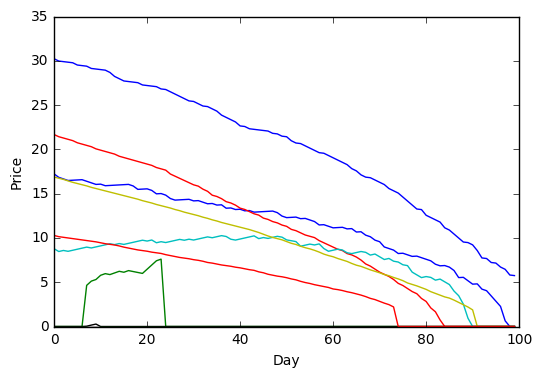

In [7]:
# sellers and buyers

for cycle in range(CYCLES):
    # reset counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = np.random.poisson(SEATS, size=N_SELLERS)
    sellers[:, 4] = -sellers[:, 3]

    buyers = add_buyer_noise(buyers)
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * price
        
    buyers = resample_buyers(buyers)
    
    # zero counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = np.random.poisson(SEATS, size=N_SELLERS)
    sellers[:, 4] = -sellers[:, 3]
    
    sellers = add_seller_noise(sellers)
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * price
            
#     sellers = resample_sellers(sellers)
    buyers = resample_buyers(buyers)
    
        # zero counters
    buyers[:, 3] = 0
    buyers[:, 4] = 0
    sellers[:, 3] = np.random.poisson(SEATS, size=N_SELLERS)
    sellers[:, 4] = -sellers[:, 3]
    
    for seller_idx in range(N_SELLERS):
        for day in range(DAYS):
            seats_left = sellers[seller_idx, 3]
            seats_record[cycle, seller_idx, day] = seats_left
            days_left = DAYS - day
            
            if seats_left <= 0:
                price = 0
            else:
                price = get_price(sellers[seller_idx, :], days_left)
            
            price_record[cycle, seller_idx, day] = price
            seats_sold, buyers = buy_tickets(buyers, seats_left, price, days_left)
            sellers[seller_idx, 3] -= seats_sold
            sellers[seller_idx, 4] += seats_sold * price
            
    sellers = resample_sellers(sellers)
    buyers = resample_buyers(buyers)
            
    
plt.plot(range(DAYS), price_record[0,0:10,:].T)
plt.ylabel('Price')
plt.xlabel('Day')   

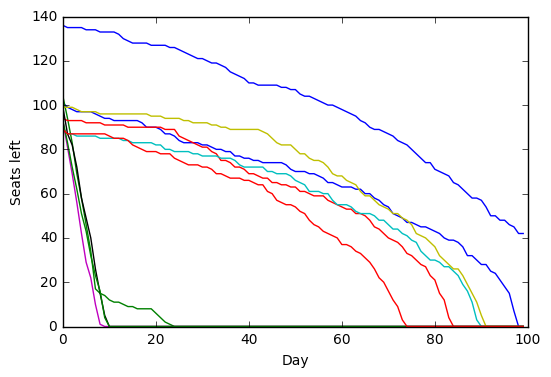

In [8]:
plt.plot(range(DAYS), seats_record[0,0:10,:].T)
plt.ylabel('Seats left')
plt.xlabel('Day')

In [9]:
sellers[:, 4]

array([ 41.65356704, -17.51482568,   2.77678615,  20.62395252,
        42.15121956,  -2.32483719,  28.21861931,  14.07004429,
        14.07004429, -20.01430127,  20.62395252,  -3.67864385,
        -1.32688586,  -7.63000488,  -1.24290091,  42.15121956,
         7.35733985,   6.08417825,  -4.02970918,  -6.93252732,
       -27.3842964 ,  32.44479578, -27.3842964 ,  11.97724672,
         7.35733985,   2.77678615,  42.15121956, -20.01430127,
       -26.07976259,  41.65356704,   1.76215913,  -4.02970918,
        19.56093117,  -6.93252732,  41.65356704,  -7.63000488,
         6.08417825, -26.07976259,  28.21861931,  16.27568816,
        -7.80258529,  -1.27738469, -12.45010752,  12.77783518,
        11.97724672, -26.07976259, -27.3842964 ,   9.6974142 ,
        24.65600196,   9.6974142 ])

In [10]:
buyers[:, 3].astype('int') - buyers[:, 4].astype('int')

array([ 2,  7,  7,  5,  5,  8,  1,  5,  5,  4,  4,  5,  3,  6,  7, -5,  9,
       -1,  4,  5,  4,  0, 13,  6,  1,  9, -1,  2,  9,  2,  8,  0, -1,  2,
        7, -1,  1,  3,  3,  4,  0, 13,  7,  6,  2, -1,  7,  3,  1,  8])

In [11]:
buyers[:,2]

array([-0.07364703, -0.05631423, -0.05631423, -0.08975714, -0.10830066,
        0.02724055, -0.12823888,  0.02724055, -0.05631423, -0.05801734,
       -0.10589971,  0.00088124, -0.10830066, -0.02375513, -0.05631423,
        0.02724055,  0.02724055, -0.12823888, -0.10830066, -0.08975714,
       -0.05801734, -0.18687158, -0.007709  , -0.02375513, -0.05020224,
       -0.04215928, -0.12823888, -0.12823888, -0.03783129, -0.12823888,
       -0.04629829, -0.11568648,  0.00088124, -0.18687158, -0.03248591,
       -0.12823888, -0.10589971, -0.10830066, -0.12823888, -0.10589971,
       -0.18687158, -0.007709  , -0.03248591, -0.02375513, -0.18687158,
        0.00088124, -0.05631423, -0.12823888, -0.05020224, -0.04629829])